In [2]:
import pandas as pd
import numpy as np
from ast import literal_eval

In [3]:
df = pd.read_csv('recipes_w_search_terms.csv')

In [5]:
# Preprocess list values
df["ingredients"] = df["ingredients"].apply(literal_eval)
df["steps"] = df["steps"].apply(literal_eval)
df["tags"] = df["tags"].apply(literal_eval)
df["search_terms"] = df["search_terms"].apply(literal_eval)

In [6]:
def categorize_mealtimes(terms):
    for meal in ['breakfast', 'lunch', 'dinner', 'dessert', "side"]:
        if meal in terms: return meal
    return 'other'

In [7]:
df["meal"] = df["search_terms"].apply(categorize_mealtimes)
df["meal"] = pd.Categorical(df["meal"])

In [64]:
df_labeled = df[df["meal"] != "other"]
df_unlabled = df[df["meal"] == "other"]

In [63]:
from sklearn.model_selection import train_test_split

ingredients = df_labeled["ingredients"].apply('\t'.join).apply(lambda x: x.replace(" ", "_"))

X_train, X_test, y_train, y_test = train_test_split(ingredients, df_labeled["meal"], test_size=.2)

In [8]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()

vec.fit(ingredients)
X = vec.transform(ingredients)


In [66]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_extraction.text import CountVectorizer


pipe = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("classifier", RidgeClassifier(tol=1e-2, solver="sparse_cg"))
])

pipe

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', RidgeClassifier(solver='sparse_cg', tol=0.01))])

In [69]:
pipe.fit(X_test, y_test)

pred = pipe.predict(X_test)

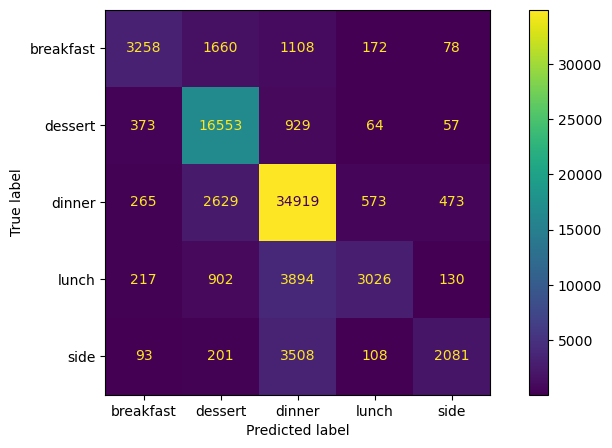

In [70]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

def confusion_matrix(predictions):
    fig, ax = plt.subplots(figsize=(10, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, predictions, ax=ax)

confusion_matrix(pred)

In [73]:
pipe.score(X_test, y_test)

0.7743784861073365

top 5 keywords per class:
       breakfast          dessert  ...            lunch       side
0           eggs            sugar  ...       mayonnaise       salt
1           milk          vanilla  ...            bread     butter
2            all            flour  ...  flour_tortillas  olive_oil
3            egg  vanilla_extract  ...    purpose_flour   potatoes
4  baking_powder    purpose_flour  ...   hamburger_buns     pepper

[5 rows x 5 columns]


Text(0.5, 1.0, 'Average feature effect on the original data')

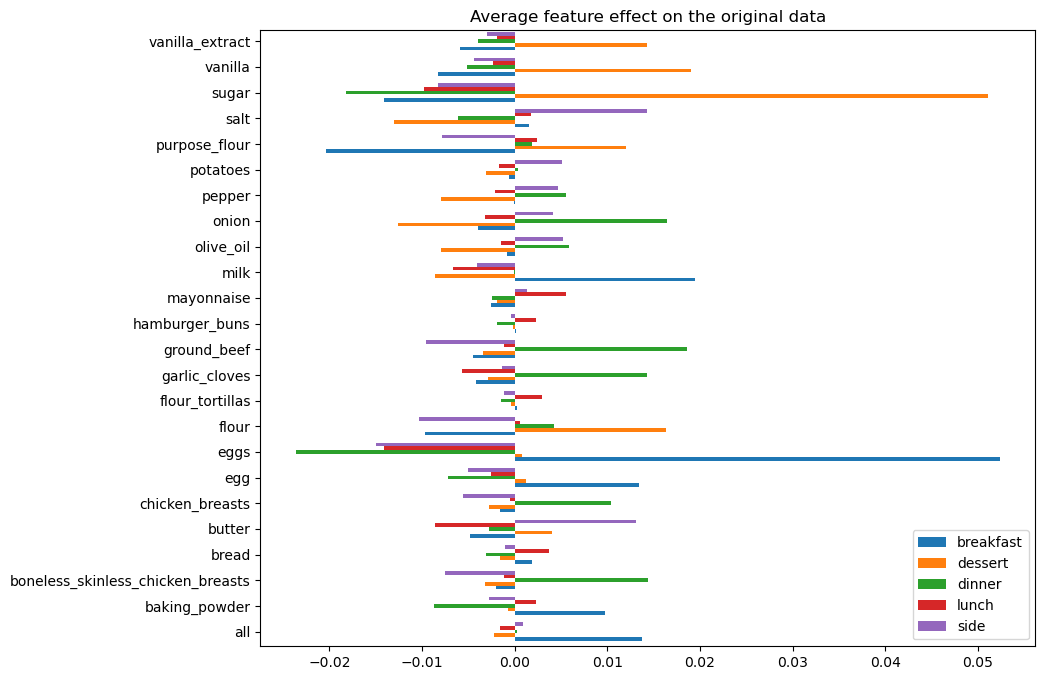

In [45]:
import numpy as np
import pandas as pd

meal_names = ['breakfast', 'dessert', 'dinner', 'lunch', "side"]
feature_names = vec.get_feature_names_out()

def plot_feature_effects(model):
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = model.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(meal_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(meal_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


plot_feature_effects(clf).set_title("Average feature effect on the original data")

In [60]:
X_train, X_test, y_train, y_test = train_test_split(ingredients, y, test_size=.2)

In [47]:
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("naive_bayes", ComplementNB())
])

pipe

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('naive_bayes', ComplementNB())])

In [48]:
parameter_grid = {
    "vectorizer__max_df": (0.2, 0.4, 0.6, 0.8, 1.0),
    "vectorizer__min_df": (1, 3, 5, 10),
    "vectorizer__ngram_range": ((1, 1), (1, 2)),  # unigrams or bigrams
    "naive_bayes__alpha": np.logspace(-6, 6, 13),
}

In [ ]:
from pprint import pprint

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=2,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'naive_bayes__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
 'vectorizer__max_df': (0.2, 0.4, 0.6, 0.8, 1.0),
 'vectorizer__min_df': (1, 3, 5, 10),
 'vectorizer__ngram_range': ((1, 1), (1, 2))}


In [52]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END naive_bayes__alpha=10000.0, vectorizer__max_df=0.6, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1); total time=   3.3s
[CV] END naive_bayes__alpha=10000.0, vectorizer__max_df=0.6, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1); total time=   3.3s
[CV] END naive_bayes__alpha=10000.0, vectorizer__max_df=0.6, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1); total time=   3.5s
[CV] END naive_bayes__alpha=10000.0, vectorizer__max_df=0.6, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1); total time=   3.5s
[CV] END naive_bayes__alpha=10000.0, vectorizer__max_df=0.6, vectorizer__min_df=10, vectorizer__ngram_range=(1, 1); total time=   3.2s
[CV] END naive_bayes__alpha=0.0001, vectorizer__max_df=0.8, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   6.1s
[CV] END naive_bayes__alpha=0.0001, vectorizer__max_df=0.8, vectorizer__min_df=3, vectorizer__ngram_range=(1, 2); total time=   5.

RandomizedSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                             ('naive_bayes', ComplementNB())]),
                   n_iter=40, n_jobs=2,
                   param_distributions={'naive_bayes__alpha': array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01,
       1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06]),
                                        'vectorizer__max_df': (0.2, 0.4, 0.6,
                                                               0.8, 1.0),
                                        'vectorizer__min_df': (1, 3, 5, 10),
                                        'vectorizer__ngram_range': ((1, 1),
                                                                    (1, 2))},
                   random_state=0, verbose=2)

In [76]:
random_search.best_params_

{'vectorizer__ngram_range': (1, 2),
 'vectorizer__min_df': 3,
 'vectorizer__max_df': 0.4,
 'naive_bayes__alpha': np.float64(0.01)}

In [53]:
test_accuracy = random_search.score(X_test, y_test)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.702
Accuracy on test set: 0.703


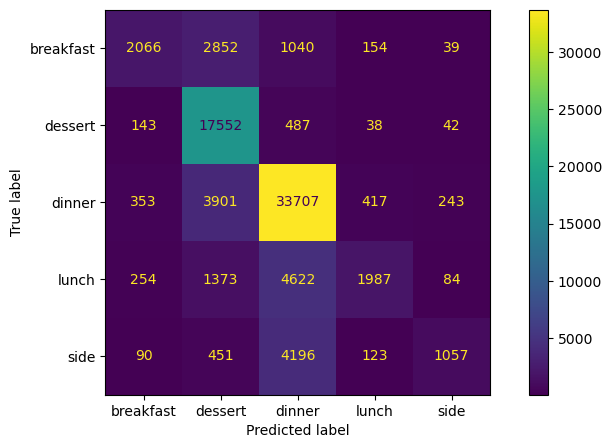

In [61]:
confusion_matrix(random_search.predict(X_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("vectorizer", CountVectorizer(
        min_df = 3,
        max_df = 0.4,
        ngram_range = (1, 2)
    )),
    ("classifier", RandomForestClassifier())
])

pipe

Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('classifier', RandomForestClassifier())])

In [77]:
parameter_grid = { 
    "classifier__n_estimators": (10, 50, 100, 200),
    "classifier__criterion": ("gini", "entropy", "log_loss"),
    "classifier__max_depth": (2, 3, 4) 
}

In [78]:
random_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=parameter_grid,
    n_iter=40,
    random_state=0,
    n_jobs=20,
    verbose=1,
)

print("Performing grid search...")
print("Hyperparameters to be evaluated:")
pprint(parameter_grid)

Performing grid search...
Hyperparameters to be evaluated:
{'classifier__criterion': ('gini', 'entropy', 'log_loss'),
 'classifier__max_depth': (2, 3, 4),
 'classifier__n_estimators': (10, 50, 100, 200)}


In [79]:
random_search.fit(X_train, y_train)

/usr/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 36 is smaller than n_iter=40. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/lib/python3.12/site-packages/numpy/ma/core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                             ('classifier',
                                              RandomForestClassifier())]),
                   n_iter=40, n_jobs=20,
                   param_distributions={'classifier__criterion': ('gini',
                                                                  'entropy',
                                                                  'log_loss'),
                                        'classifier__max_depth': (2, 3, 4),
                                        'classifier__n_estimators': (10, 50,
                                                                     100,
                                                                     200)},
                   random_state=0, verbose=1)

In [80]:
test_accuracy = random_search.score(X_test, y_test)
print(
    "Accuracy of the best parameters using the inner CV of "
    f"the random search: {random_search.best_score_:.3f}"
)
print(f"Accuracy on test set: {test_accuracy:.3f}")

Accuracy of the best parameters using the inner CV of the random search: 0.508
Accuracy on test set: 0.516
